In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer
import random
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
!pip install sentence_transformers
!pip install PyMuPDF
import fitz
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
from transformers import pipeline

from IPython.display import display, HTML

from typing import List, Callable, Dict, Tuple, Set
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_colwidth', 600)
pd.set_option('display.max_rows', 500)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 911.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=f93d49eaaf2769aef0281c3f145898872b4d352f7f1c94c2d99b7e4fdaa4d82f
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 32.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Define Fucntions**

## **Extract country content, sections, and laws from PDF**

In [14]:
def extract_country_content_with_sections(file_path):
    data = []
    with fitz.open(file_path) as doc:
        first_pages_text = "\n".join([doc.load_page(i).get_text() for i in range(5)])
        country_pattern = r"(\b[A-Z][a-z]+(?:\s[A-Z][a-z]+)*)(?:\s*\.\s*)+(\d+)"
        countries = re.findall(country_pattern, first_pages_text)

        section_headers = [
            "LAW", "DEFINITIONS", "NATIONAL DATA PROTECTION AUTHORITY",
            "REGISTRATION", "DATA PROTECTION OFFICERS", "COLLECTION & PROCESSING",
            "TRANSFER", "SECURITY", "BREACH NOTIFICATION", "ENFORCEMENT",
            "ELECTRONIC MARKETING", "ONLINE PRIVACY","KEY CONTACTS"
        ]

        for i in range(len(countries) - 1):
            country, start_page = countries[i]
            _, next_page = countries[i + 1]
            start_page, next_page = int(start_page) - 1, int(next_page) - 1

            content = ""
            for p in range(start_page, next_page):
                page = doc.load_page(p)
                content += page.get_text()

            sections = {}
            current_section = None
            for line in content.splitlines():
                if line.isupper() and any(header == line.strip() for header in section_headers):
                    current_section = line.strip()
                    sections[current_section] = ""
                elif current_section:
                    sections[current_section] += line + "\n"

            data.append([country, sections])

    return pd.DataFrame(data, columns=["Country", "Sections"])

## **Clean the extracted content**

In [15]:
def clean_content(df):
    patterns_to_remove = ['\n', 'www.dlapiperdataprotection.com', 'DATA PROTECTION LAWS OF THE WORLD  Data Protection Laws of the World']

    for index, row in df.iterrows():
        updated_sections = {}
        for section, content in row['Sections'].items():
            for pattern in patterns_to_remove:
                content = content.replace(pattern, '')
            updated_sections[section] = content
        df.at[index, 'Sections'] = updated_sections

    return df

## **Extract Law Entity Using NER**

In [16]:
# Extract law entities
nlp = spacy.load('en_core_web_sm')
def extract_law_entities(df):
    law_entities = []

    for index, row in df.iterrows():
        country_law_entities = []
        for section, content in row['Sections'].items():
            doc = nlp(content)
            country_law_entities.extend([ent.text for ent in doc.ents if ent.label_ == 'LAW'])
        law_entities.append(country_law_entities)

    df['Law Entities'] = law_entities
    return df

## **More Cleaning: Remove country number pattern**

In [17]:
def remove_country_number_pattern(df):
    country_names = '|'.join(df['Country'].apply(re.escape))
    pattern = rf"({country_names})\s+\d+\s*\|\|\|"

    for index, row in df.iterrows():
        updated_sections = {}
        for section, content in row['Sections'].items():
            updated_content = re.sub(pattern, '', content)
            updated_sections[section] = updated_content
        df.at[index, 'Sections'] = updated_sections

    return df

## **Greeting Function**

In [18]:
def greeting(sentence):
    GREETING_INPUTS = ("hello", "hi", "greetings", "sup", "what's up", "hey",)
    GREETING_RESPONSES = ["hi", "hey", "*nods*", "hi there", "hello", "I am glad! You are talking to me"]
    for word in sentence.split():
        if word.lower() in GREETING_INPUTS:
            return random.choice(GREETING_RESPONSES)

## **Load SentenceTransformer model: multi-qa-MiniLM-L6-cos-v1**

In [19]:
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

## **Find the most relevant country (transformer) and section (tf-idf)**

In [20]:
def find_most_relevant_country(user_input, df):
    country_names = df['Country'].tolist()
    country_embeddings = model.encode(country_names, convert_to_tensor=True)
    user_input_embedding = model.encode([user_input], convert_to_tensor=True)

    country_embeddings = country_embeddings.cpu()
    user_input_embedding = user_input_embedding.cpu()

    cosine_scores = cosine_similarity(user_input_embedding, country_embeddings)[0]
    most_relevant_country_idx = np.argmax(cosine_scores)
    return country_names[most_relevant_country_idx]

# Find the most relevant section within a country
def find_most_relevant_section(user_input, country, df):
    sections = df[df['Country'] == country]['Sections'].values[0]
    section_headers = list(sections.keys())

    vectorizer = TfidfVectorizer()
    section_headers_tfidf = vectorizer.fit_transform(section_headers)

    user_input_tfidf = vectorizer.transform([user_input])

    cosine_scores = cosine_similarity(user_input_tfidf, section_headers_tfidf)[0]
    most_relevant_section_idx = np.argmax(cosine_scores)
    return section_headers[most_relevant_section_idx]

## **Generate response：multi-qa-MiniLM-L6-cos-v1**

In [21]:
def generate_response(user_input, country, section, df):
    content = df[df['Country'] == country]['Sections'].values[0][section]

    # Adjust sentence splitting to not break at 'No.'
    sentences = re.split(r'(?<!\bNo)\. ', content)

    embeddings = model.encode([user_input] + sentences, convert_to_tensor=True)
    embeddings = embeddings.cpu()

    question_embedding = embeddings[0].unsqueeze(0)
    sentence_embeddings = embeddings[1:]
    cosine_scores = cosine_similarity(question_embedding, sentence_embeddings)[0]

    most_relevant_sentence_idx = np.argmax(cosine_scores)
    return sentences[most_relevant_sentence_idx]

## **Use Law in User Input to locate country**

In [22]:
# Extract laws from input
def extract_laws_from_input(user_input):
    doc = nlp(user_input)
    return [ent.text for ent in doc.ents if ent.label_ == 'LAW']

# Find countries by laws
def find_countries_by_laws(laws, df):
    matching_countries = set()
    for law in laws:
        for index, row in df.iterrows():
            if law in row['Law Entities']:
                matching_countries.add(row['Country'])
    return list(matching_countries)
# For Ontology
def create_section_law_dict(row):
    sections = row['Sections']
    law_entities = row['Law Entities']

    # Initialize a dictionary for section-law mappings
    section_law_dict = {}

    # Iterate through each section and its index
    for idx, section in enumerate(sections):
        # Extract corresponding law entities if available
        section_law_entities = law_entities[idx] if idx < len(law_entities) else []
        section_law_dict[section] = section_law_entities

    return section_law_dict

## **Chatbot main function**

In [23]:
def chatbot_main(user_input, df):
    if user_input.lower() in ['bye', 'exit', 'quit']:
        return "Bye! take care..", None

    if greeting(user_input) is not None:
        return greeting(user_input), None

    mentioned_laws = extract_laws_from_input(user_input)
    matching_countries = find_countries_by_laws(mentioned_laws, df)

    if matching_countries:
        responses = []
        for country in matching_countries:
            section = find_most_relevant_section(user_input, country, df)
            response = generate_response(user_input, country, section, df)
            responses.append((country, section, response))
        return responses
    else:
        country = find_most_relevant_country(user_input, df)
        section = find_most_relevant_section(user_input, country, df)
        response = generate_response(user_input, country, section, df)
        return [(country, section, response)]

# **Load and process the data**

In [24]:
file_path_pdf = '/content/gdrive/MyDrive/Data-Protection-Full.pdf'
country_df_pdf = extract_country_content_with_sections(file_path_pdf)
country_df_pdf = clean_content(country_df_pdf)
country_df_pdf = remove_country_number_pattern(country_df_pdf)
country_df_pdf = extract_law_entities(country_df_pdf)

In [ ]:
country_df_pdf['Section-Law Mapping'] = country_df_pdf.apply(create_section_law_dict, axis=1)

In [ ]:
country_df_pdf

,Country,Sections,Law Entities,Section-Law Mapping
0,Albania,"{'LAW': 'The Republic of Albania regulates personal data protection pursuant to Law No. 9887, dated 10 March 2008 ""On Protection ofPersonal Data"", as amended ("""") (Official Gazette of the Republic of Albania No. 44, dated 1 April 2008).Data Protection LawThe Data Protection Law was last amended in 2014, thus it is yet to be harmonized with the Regulation (EU) 2016/679 of theEuropean Parliament and of the Council of 27 April 2016 on the protection of natural persons with regard to the processing ofpersonal data and on the free movement of such data (""""). GDPRThe complete harmonization of th...","[Protocol, the Labour Code, Protocol, The Electronic Communications Law, article 122, the Electronic Communications Law, the Data Protection Law, article 39, Article 39, the Data Protection Law, the Data Protection Law, article 124, the Electronic Communications Law, the Data Protection Law, the Data Protection Law, the Electronic Communication Law, The Electronic Communication Law, the Electronic Communication Law]","{'LAW': 'Protocol', 'DEFINITIONS': 'the Labour Code', 'NATIONAL DATA PROTECTION AUTHORITY': 'Protocol', 'REGISTRATION': 'The Electronic Communications Law', 'DATA PROTECTION OFFICERS': 'article 122', 'COLLECTION & PROCESSING': 'the Electronic Communications Law', 'TRANSFER': 'the Data Protection Law', 'SECURITY': 'article 39', 'BREACH NOTIFICATION': 'Article 39', 'ENFORCEMENT': 'the Data Protection Law', 'ELECTRONIC MARKETING': 'the Data Protection Law', 'ONLINE PRIVACY': 'article 124', 'KEY CONTACTS': 'the Electronic Communications Law'}"
1,Algeria,"{'LAW': 'Law No. 18-07 of 10 June 2018 on protection of natural persons in personal data processing (“”).Law No. 18-07', 'DEFINITIONS': 'Definition of Personal DataAny information, regardless of the medium, relating to an identified or identifiable person, hereinafter referred to as ""data subject"",directly or indirectly, in particular by reference to an identification number or to one or more factors specific to his or herphysical, physiological, genetic, biometric, mental, economic, cultural or social identity.Definition of Sensitive Personal DataPersonal data revealing racial or ethnic o...",[],"{'LAW': [], 'DEFINITIONS': [], 'NATIONAL DATA PROTECTION AUTHORITY': [], 'REGISTRATION': [], 'DATA PROTECTION OFFICERS': [], 'COLLECTION & PROCESSING': [], 'TRANSFER': [], 'SECURITY': [], 'BREACH NOTIFICATION': [], 'ENFORCEMENT': [], 'ELECTRONIC MARKETING': [], 'ONLINE PRIVACY': [], 'KEY CONTACTS': []}"
2,Angola,"{'LAW': 'Angola regulates data privacy and protection issues under the Data Protection Law (Law no. 22/11, 17 June 2011), the ElectronicCommunications and Information Society Services Law (Law no. 23/11, 20 June 2011) and the Protection of Information Systemsand Networks Law (Law no. 7/17, 16 February 2017).', 'DEFINITIONS': 'Definition of personal dataThe Data Protection Law defines personal data as any given information, regardless of its nature, including images and soundsrelated to a specific or identifiable individual.An identifiable person is an individual directly or indirectly iden...","[the Data Protection Law, dataThe Data Protection Law, The Data Protection Law, the Presidential Decree 214/2016, the Data Protection Law]","{'LAW': 'the Data Protection Law', 'DEFINITIONS': 'dataThe Data Protection Law', 'NATIONAL DATA PROTECTION AUTHORITY': 'The Data Protection Law', 'REGISTRATION': 'the Presidential Decree 214/2016', 'DATA PROTECTION OFFICERS': 'the Data Protection Law', 'COLLECTION & PROCESSING': [], 'TRANSFER': [], 'SECURITY': [], 'BREACH NOTIFICATION': [], 'ENFORCEMENT': [], 'ELECTRONIC MARKETING': [], 'ONLINE PRIVACY': [], 'KEY CONTACTS': []}"
3,Argentina,"{'LAW': 'Article 43 of the Federal Constitution, third paragraph, provides, in relevant part that any person may file an action to have accessto personal data about such person and to information about the purpose with which they are kept, 

# **Part I - Ontology**

In [ ]:
import networkx as nx
import ast

G = nx.Graph()

# Iterate over the DataFrame to add nodes and edges
for index, row in country_df_pdf.iterrows():
    country = row['Country']
    G.add_node(country, type='country')

    # Safely evaluate the string literal if necessary
    section_law_dict = ast.literal_eval(row['Section-Law Mapping']) if isinstance(row['Section-Law Mapping'], str) else row['Section-Law Mapping']

    for section, laws in section_law_dict.items():
        section_node = f"{country}-{section}"
        G.add_node(section_node, type='section')
        G.add_edge(country, section_node)

        if isinstance(laws, list):  # Check if laws is a list
            for law in laws:
                law_node = f"{section_node}-{law}"
                G.add_node(law_node, type='law')
                G.add_edge(section_node, law_node)
        else:  # If laws is a single law (string)
            law_node = f"{section_node}-{laws}"
            G.add_node(law_node, type='law')
            G.add_edge(section_node, law_node)

# Visualize the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=2500, font_size=8)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### **United Kingdom**

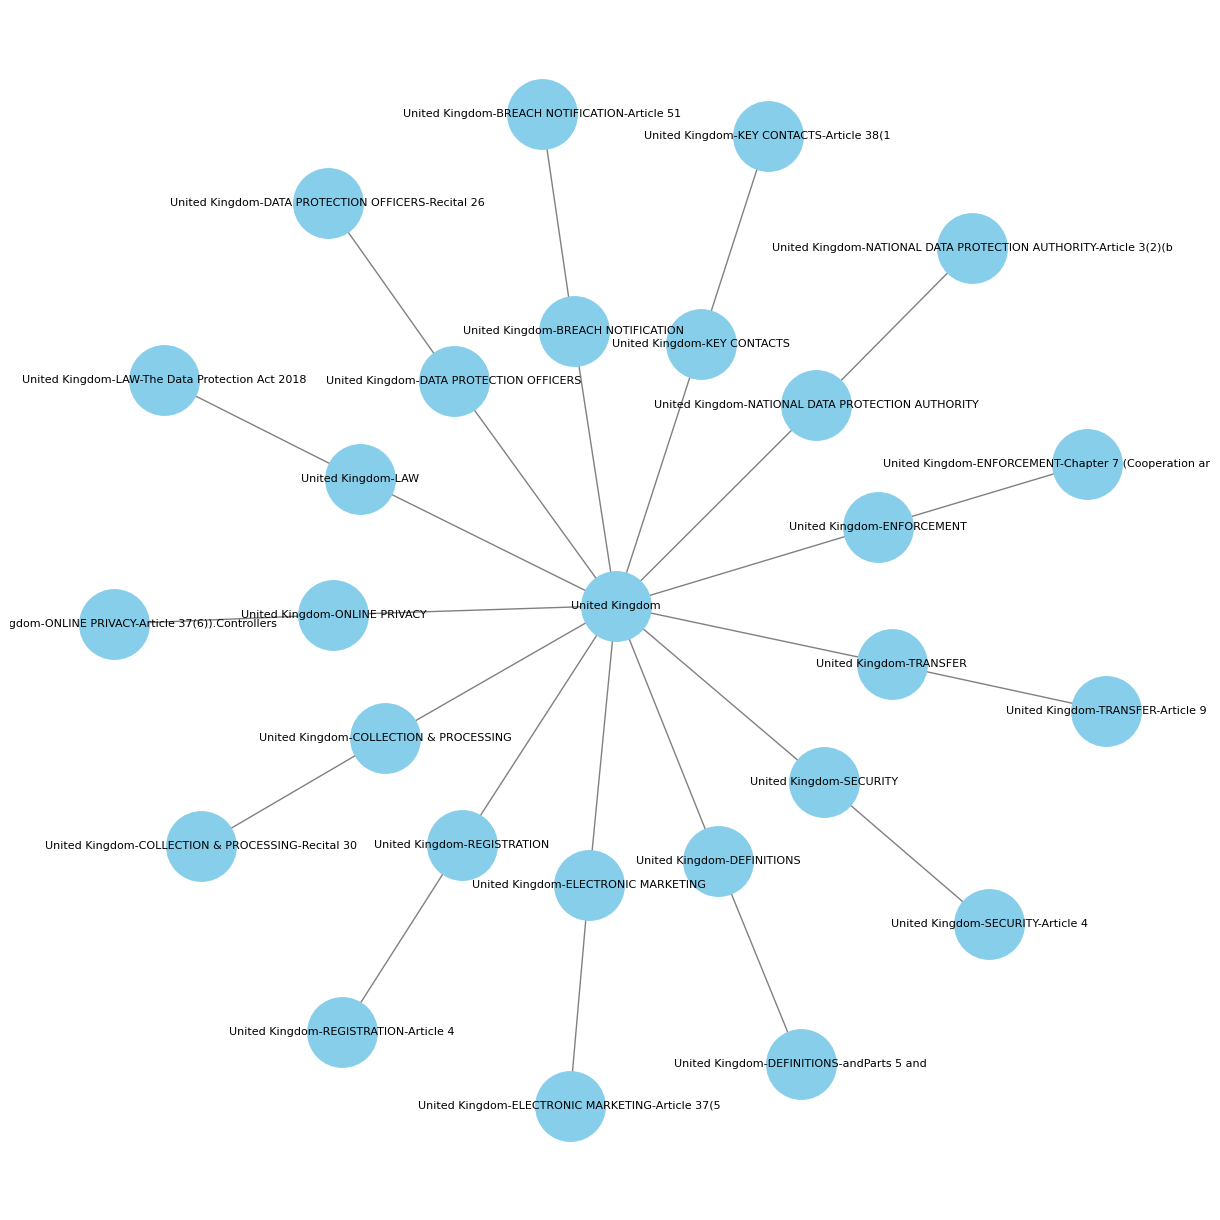

In [ ]:
def filter_and_visualize(graph, country, section=None):
    related_nodes = [country]

    if section:
        # Filter for a specific section within the country
        section_node_name = f"{country}-{section}"
        if section_node_name in graph.nodes():
            related_nodes.append(section_node_name)

            # Add all law nodes related to the specific section
            for node in graph.nodes(data=True):
                node_name, node_attr = node
                if node_attr['type'] == 'law' and section_node_name in node_name:
                    related_nodes.append(node_name)
    else:
        # Filter for the entire country
        for node in graph.nodes(data=True):
            node_name, node_attr = node
            if node_attr['type'] == 'country' and node_name == country:
                related_nodes.append(node_name)
            elif node_attr['type'] in ['section', 'law'] and country in node_name:
                related_nodes.append(node_name)

    # Create a subgraph with the related nodes
    subgraph = graph.subgraph(related_nodes)

    # Visualize the subgraph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(subgraph)  # Positions for all nodes in the subgraph
    nx.draw(subgraph, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=2500, font_size=8)
    plt.show()

filter_and_visualize(G, 'United Kingdom')



### **United States**

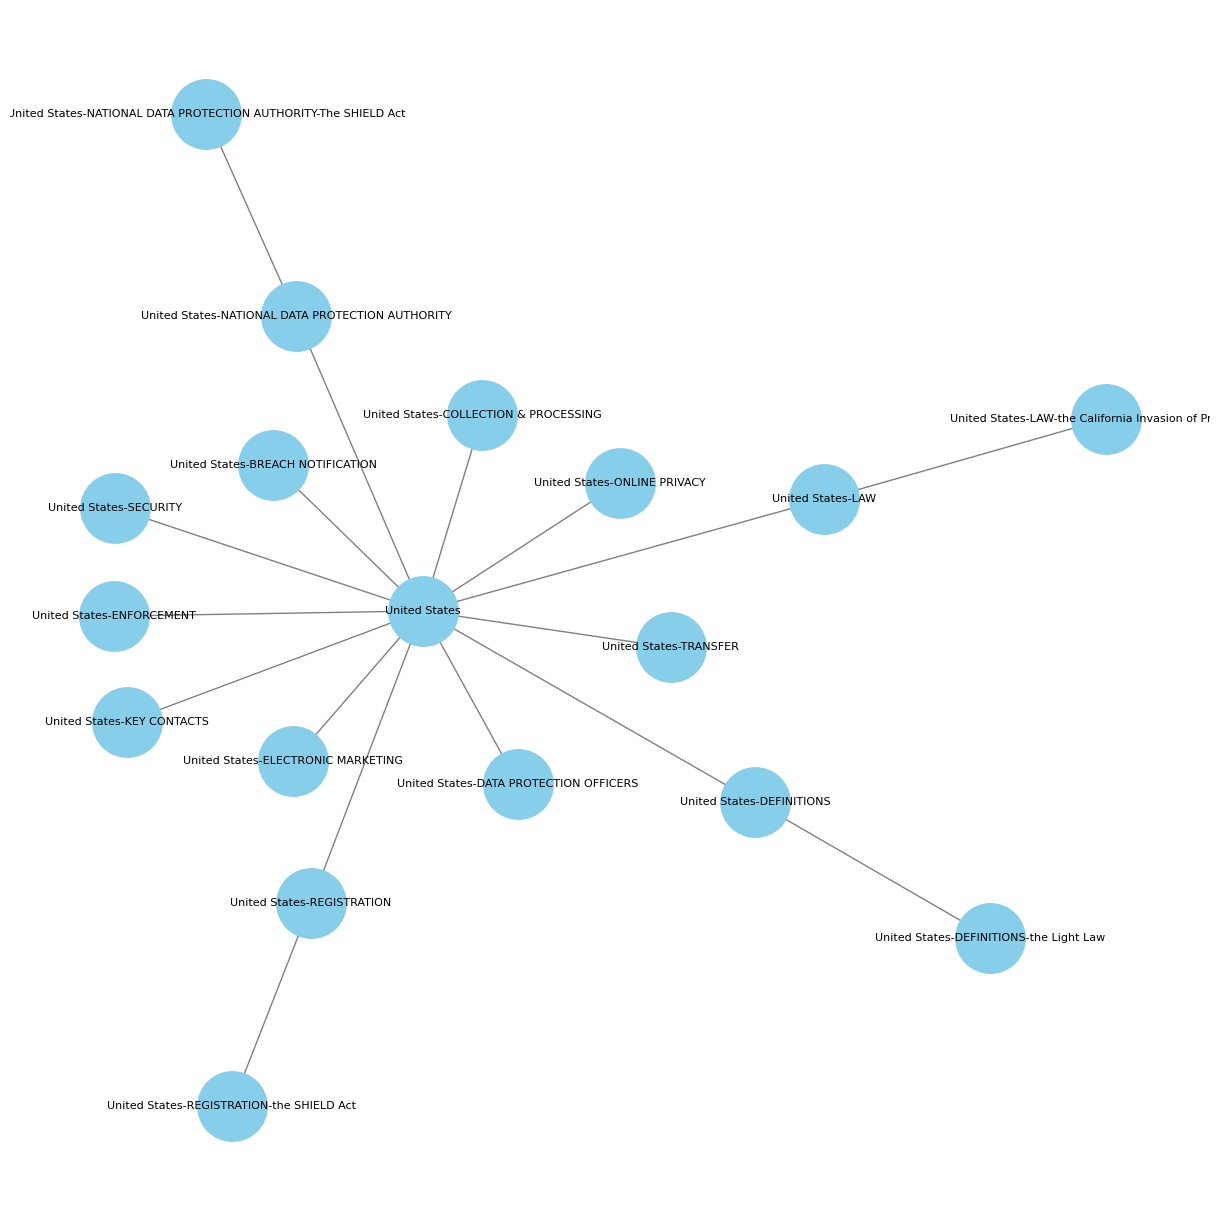

In [ ]:
filter_and_visualize(G, 'United States')

### **France**

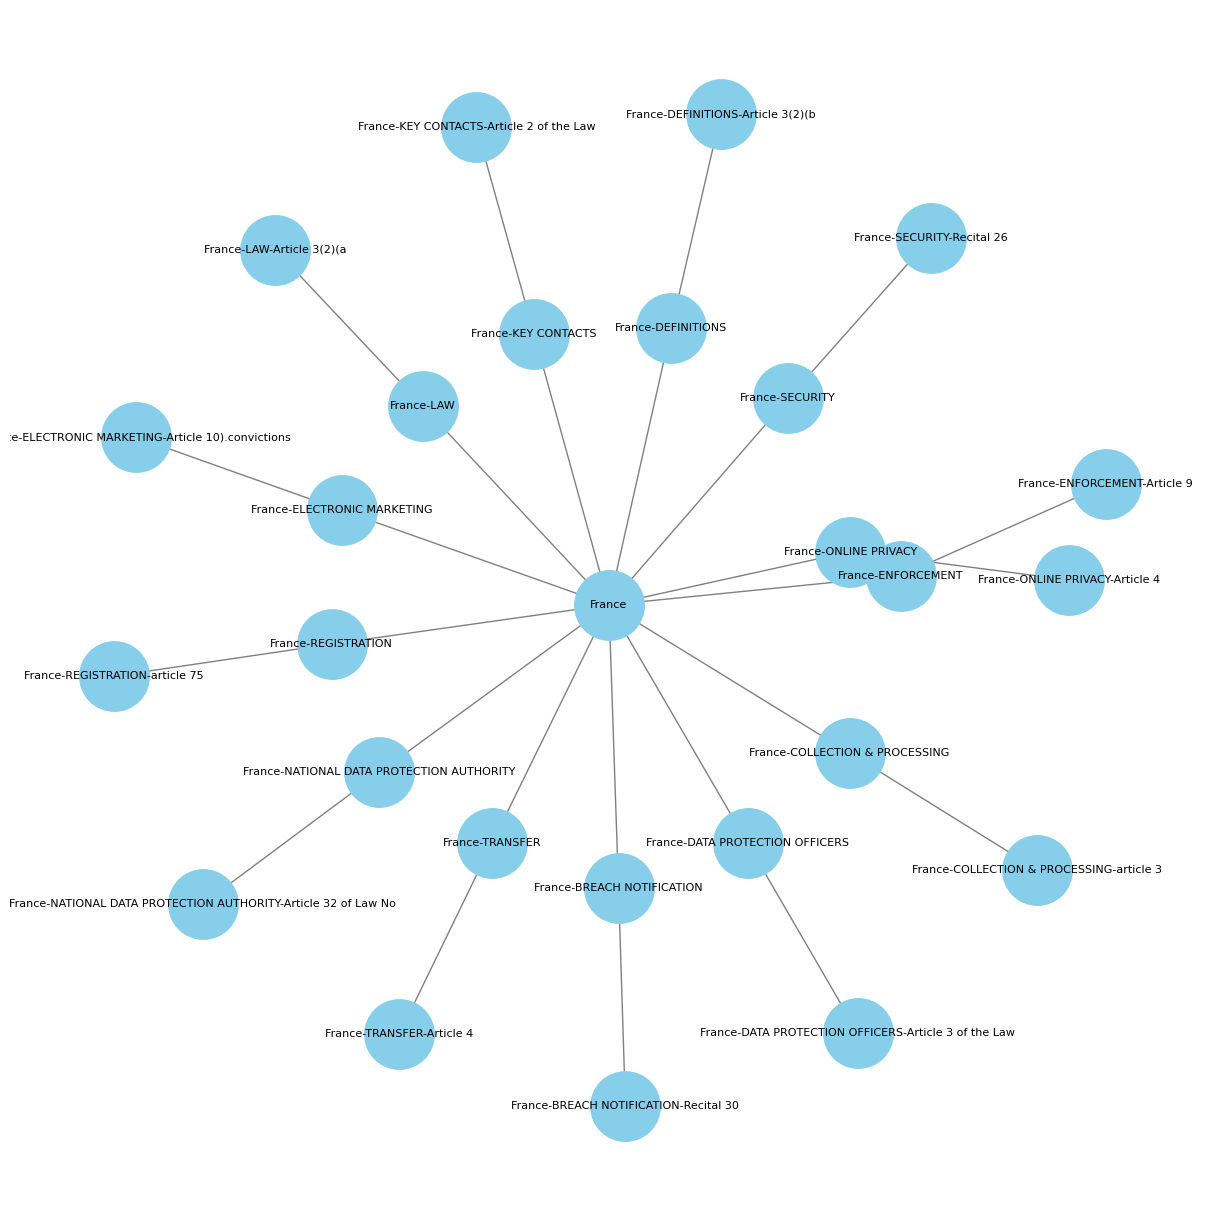

In [ ]:
filter_and_visualize(G, 'France')

# **Part II - Country Choice**

### **Transformer Model: multi-qa-MiniLM-L6-cos-v1**

In [ ]:
def chatbot_main(user_input, df):
    if user_input.lower() in ['bye', 'exit', 'quit']:
        return "Bye! Take care."

    # Check for a greeting and respond accordingly
    greeting_response = greeting(user_input)
    if greeting_response is not None:
        return greeting_response

    # Find the most relevant country based on user input
    country = find_most_relevant_country(user_input, df)
    return country
flag = True
print("Welcome to the World Data Protection Chatbot. My name is Alex. To end session please type exit")
while flag:
    user_input = input("You: ").lower()
    if user_input != 'exit':
        if user_input in ['thanks', 'thank you']:
            flag = False
            print("Alex: You are welcome!")
        else:
            if greeting(user_input) is not None:
                print("Alex: " + greeting(user_input))
            else:
                response = chatbot_main(user_input, country_df_pdf)
                if isinstance(response, str):
                    print("Alex: " + response)
                else:
                    for country, section, resp in response:
                        print(f"Alex [{country} - {section}]: {resp}")
    else:
        flag = False
        print("Thank you for using the World Data Protection Chatbot. Good bye.")

Welcome to the World Data Protection Chatbot. My name is Alex. To end session please type exit
You: what are the laws in United States?
Alex: United States
You: who are the data authority in Albania?
Alex: Albania
You: Wht are the regulation for online privacy in United Kingdom?
Alex: United Kingdom
You: What's the defintion of personal identify information in France?
Alex: France
You: Who are the key contacts for data regulations in Greece?
Alex: Greece
You: exit
Thank you for using the World Data Protection Chatbot. Good bye.


### **distilbert-base-uncased-distilled-squad**

In [27]:
model2 = SentenceTransformer('distilbert-base-uncased-distilled-squad')

.gitattributes:   0%|          | 0.00/445 [00:00<?, ?B/s]

384-8bits.tflite:   0%|          | 0.00/67.6M [00:00<?, ?B/s]

384-fp16.tflite:   0%|          | 0.00/133M [00:00<?, ?B/s]

384.tflite:   0%|          | 0.00/265M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

coreml_model.mlmodel:   0%|          | 0.00/265M [00:00<?, ?B/s]

coreml_model_fp16.mlmodel:   0%|          | 0.00/181M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/265M [00:00<?, ?B/s]

saved_model.tar.gz:   0%|          | 0.00/245M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
def find_most_relevant_country(user_input, df):
    country_names = df['Country'].tolist()
    country_embeddings = model2.encode(country_names, convert_to_tensor=True)
    user_input_embedding = model2.encode([user_input], convert_to_tensor=True)

    country_embeddings = country_embeddings.cpu()
    user_input_embedding = user_input_embedding.cpu()

    cosine_scores = cosine_similarity(user_input_embedding, country_embeddings)[0]
    most_relevant_country_idx = np.argmax(cosine_scores)
    return country_names[most_relevant_country_idx]

flag = True
print("Welcome to the World Data Protection Chatbot. My name is Alex. To end session please type exit")
while flag:
    user_input = input("You: ").lower()
    if user_input != 'exit':
        if user_input in ['thanks', 'thank you']:
            flag = False
            print("Alex: You are welcome!")
        else:
            if greeting(user_input) is not None:
                print("Alex: " + greeting(user_input))
            else:
                response = chatbot_main(user_input, country_df_pdf)
                if isinstance(response, str):
                    print("Alex: " + response)
                else:
                    for country, section, resp in response:
                        print(f"Alex [{country} - {section}]: {resp}")
    else:
        flag = False
        print("Thank you for using the World Data Protection Chatbot. Good bye.")

Welcome to the World Data Protection Chatbot. My name is Alex. To end session please type exit
You: what are the laws in United States?
Alex: Sint Maarten
You: who are the data authority in Albania?
Alex: Sint Maarten
You: Wht are the regulation for online privacy in United Kingdom?
Alex: Abu Dhabi Global Market Free Zone
You: What's the defintion of personal identify information in France?
Alex: Abu Dhabi Global Market Free Zone
You: Who are the key contacts for data regulations in Greece?
Alex: Sint Maarten
You: exit
Thank you for using the World Data Protection Chatbot. Good bye.


### **TF - IDF**

In [ ]:

def find_most_relevant_country(user_input, df):
    country_names = df['Country'].tolist()

    vectorizer = TfidfVectorizer()
    country_tfidf = vectorizer.fit_transform(country_names)

    # Transform the user input
    user_input_tfidf = vectorizer.transform([user_input])

    # Compute cosine similarity
    cosine_scores = cosine_similarity(user_input_tfidf, country_tfidf)[0]
    most_relevant_country_idx = np.argmax(cosine_scores)

    return country_names[most_relevant_country_idx]
flag = True
print("Welcome to the World Data Protection Chatbot. My name is Alex. To end session please type exit")
while flag:
    user_input = input("You: ").lower()
    if user_input != 'exit':
        if user_input in ['thanks', 'thank you']:
            flag = False
            print("Alex: You are welcome!")
        else:
            if greeting(user_input) is not None:
                print("Alex: " + greeting(user_input))
            else:
                response = chatbot_main(user_input, country_df_pdf)
                if isinstance(response, str):
                    print("Alex: " + response)
                else:
                    for country, section, resp in response:
                        print(f"Alex [{country} - {section}]: {resp}")
    else:
        flag = False
        print("Thank you for using the World Data Protection Chatbot. Good bye.")

Welcome to the World Data Protection Chatbot. My name is Alex. To end session please type exit
You: what are the laws in United States?
Alex: United States
You: who are the data authority in Albania?
Alex: Albania
You: Wht are the regulation for online privacy in United Kingdom?
Alex: United Kingdom
You: What's the defintion of personal identify information in France?
Alex: France
You: Who are the key contacts for data regulations in Greece?
Alex: Greece
You: exit
Thank you for using the World Data Protection Chatbot. Good bye.


# **Part III - Section Choices**

### **TF - IDF**

In [25]:
def chatbot_main(user_input, df):
    # Check if user inputs a command to exit the chat
    if user_input.lower() in ['bye', 'exit', 'quit']:
        return "Bye! Take care."

    # Check for a greeting and respond accordingly
    greeting_response = greeting(user_input)
    if greeting_response is not None:
        return greeting_response

    # Find the most relevant country based on user input
    country = find_most_relevant_country(user_input, df)

    # Find the most relevant section within the identified country
    section = find_most_relevant_section(user_input, country, df)

    return country, section
flag = True
print("Welcome to the World Data Protection Chatbot. My name is Alex. To end the session, please type exit.")
while flag:
    user_input = input("You: ").lower()
    if user_input != 'exit':
        if user_input in ['thanks', 'thank you']:
            flag = False
            print("Alex: You are welcome!")
        else:
            response = chatbot_main(user_input, country_df_pdf)
            if isinstance(response, str):
                print("Alex: " + response)
            else:
                # Correctly handling the tuple returned by chatbot_main
                country, section = response
                print(f"Alex [{country} - {section}]")
    else:
        flag = False
        print("Thank you for using the World Data Protection Chatbot. Goodbye.")

Welcome to the World Data Protection Chatbot. My name is Alex. To end the session, please type exit.
You: What are the laws in United States?
Alex [United States - LAW]
You: Who are the data uathorith in Albania?
Alex [Albania - DATA PROTECTION OFFICERS]
You: Provide me the contacts of data protection officers in United States
Alex [United States - DATA PROTECTION OFFICERS]
You: Should I have a breach notification for online privacy data leakage in France?
Alex [France - BREACH NOTIFICATION]
You: who are the key contacts in United States regarding data privacy law
Alex [United States - KEY CONTACTS]
You: exit
Thank you for using the World Data Protection Chatbot. Goodbye.


### **distilbert-base-uncased-distilled-squad**

In [28]:
def find_most_relevant_section(user_input, country, df):
    sections = df[df['Country'] == country]['Sections'].values[0]
    section_headers = list(sections.keys())

    # Encode the section headers and user input using the model
    section_headers_embeddings = model2.encode(section_headers, convert_to_tensor=True)
    user_input_embedding = model2.encode([user_input], convert_to_tensor=True)

    # Move tensors to CPU for cosine similarity calculation
    section_headers_embeddings = section_headers_embeddings.cpu()
    user_input_embedding = user_input_embedding.cpu()

    # Compute cosine similarity
    cosine_scores = cosine_similarity(user_input_embedding, section_headers_embeddings)[0]
    most_relevant_section_idx = np.argmax(cosine_scores)
    return section_headers[most_relevant_section_idx]
flag = True
print("Welcome to the World Data Protection Chatbot. My name is Alex. To end the session, please type exit.")
while flag:
    user_input = input("You: ").lower()
    if user_input != 'exit':
        if user_input in ['thanks', 'thank you']:
            flag = False
            print("Alex: You are welcome!")
        else:
            response = chatbot_main(user_input, country_df_pdf)
            if isinstance(response, str):
                print("Alex: " + response)
            else:
                # Correctly handling the tuple returned by chatbot_main
                country, section = response
                print(f"Alex [{country} - {section}]")
    else:
        flag = False
        print("Thank you for using the World Data Protection Chatbot. Goodbye.")

Welcome to the World Data Protection Chatbot. My name is Alex. To end the session, please type exit.
You: What are the laws in United States?
Alex [United States - NATIONAL DATA PROTECTION AUTHORITY]
You: Who are the data uathorith in Albania?
Alex [Albania - NATIONAL DATA PROTECTION AUTHORITY]
You: Provide me the contacts of data protection officers in United States
Alex [United States - DATA PROTECTION OFFICERS]
You: Should I have a breach notification for online privacy data leakage in France?
Alex [France - NATIONAL DATA PROTECTION AUTHORITY]
You: who are the key contacts in United States regarding data privacy law
Alex [United States - NATIONAL DATA PROTECTION AUTHORITY]
You: exit
Thank you for using the World Data Protection Chatbot. Goodbye.


### **Transformer Model: multi-qa-MiniLM-L6-cos-v1**

In [29]:
def find_most_relevant_section(user_input, country, df):
    sections = df[df['Country'] == country]['Sections'].values[0]
    section_headers = list(sections.keys())

    # Encode the section headers and user input using the model
    section_headers_embeddings = model.encode(section_headers, convert_to_tensor=True)
    user_input_embedding = model.encode([user_input], convert_to_tensor=True)

    # Move tensors to CPU for cosine similarity calculation
    section_headers_embeddings = section_headers_embeddings.cpu()
    user_input_embedding = user_input_embedding.cpu()

    # Compute cosine similarity
    cosine_scores = cosine_similarity(user_input_embedding, section_headers_embeddings)[0]
    most_relevant_section_idx = np.argmax(cosine_scores)
    return section_headers[most_relevant_section_idx]
flag = True
print("Welcome to the World Data Protection Chatbot. My name is Alex. To end the session, please type exit.")
while flag:
    user_input = input("You: ").lower()
    if user_input != 'exit':
        if user_input in ['thanks', 'thank you']:
            flag = False
            print("Alex: You are welcome!")
        else:
            response = chatbot_main(user_input, country_df_pdf)
            if isinstance(response, str):
                print("Alex: " + response)
            else:
                # Correctly handling the tuple returned by chatbot_main
                country, section = response
                print(f"Alex [{country} - {section}]")
    else:
        flag = False
        print("Thank you for using the World Data Protection Chatbot. Goodbye.")

Welcome to the World Data Protection Chatbot. My name is Alex. To end the session, please type exit.
You: What are the laws in United States?
Alex [United States - LAW]
You: Who are the data uathorith in Albania?
Alex [Albania - NATIONAL DATA PROTECTION AUTHORITY]
You: Provide me the contacts of data protection officers in United States
Alex [United States - DATA PROTECTION OFFICERS]
You: Should I have a breach notification for online privacy data leakage in France?
Alex [France - BREACH NOTIFICATION]
You: who are the key contacts in United States regarding data privacy law
Alex [United States - NATIONAL DATA PROTECTION AUTHORITY]
You: exit
Thank you for using the World Data Protection Chatbot. Goodbye.


# **Part IV - Content Choice**

### **Transformer Model: multi-qa-MiniLM-L6-cos-v1**

In [ ]:
flag = True
print("Welcome to the World Data Protection Chatbot. My name is Alex. To end session please type exit")
while flag:
    user_input = input("You: ").lower()
    if user_input != 'exit':
        if user_input in ['thanks', 'thank you']:
            flag = False
            print("Alex: You are welcome!")
        else:
            if greeting(user_input) is not None:
                print("Alex: " + greeting(user_input))
            else:
                response = chatbot_main(user_input, country_df_pdf)
                if isinstance(response, str):
                    print("Alex: " + response)
                else:
                    for country, section, resp in response:
                        print(f"Alex [{country} - {section}]: {resp}")
    else:
        flag = False
        print("Thank you for using the World Data Protection Chatbot. Good bye.")

Welcome to the World Data Protection Chatbot. My name is Alex. To end session please type exit
You: what are the laws in United States?>
Alex [United States - LAW]:  US states have also passed privacy and data security laws and regulationsthat apply across sectors and go beyond federal law—such as data security laws, secure destruction, Social Security numberprivacy, online privacy, biometric information privacy, and data breach notification laws
You: what is GDPR
Alex [Guatemala - LAW]: Guatemala does not have a personal data protection law, however the Law on Access to Public Information (Ley de Acceso a laInformación Pública – Decree 57-2008 of the Congress of the Republic), even if it pertains to information in public files and records,does address the matter in certain provisions which can be applicable to private parties.
You: what are the laws in Albania
Alex [Albania - LAW]: As of December 2022 this draft law has yet to be approved by theAlbanian Parliament.Earlier in the year,

### **TF - IDF**

In [ ]:

def generate_response(user_input, country, section, df):
    content = df[df['Country'] == country]['Sections'].values[0][section]

    # Adjust sentence splitting to not break at 'No.'
    sentences = re.split(r'(?<!\bNo)\. ', content)

    # Combine user input with sentences for TF-IDF transformation
    combined_text = [user_input] + sentences

    # Create and fit the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(combined_text)

    # Compute cosine similarity between user input and each sentence
    cosine_scores = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])

    # Find the index of the sentence with the highest similarity
    most_relevant_sentence_idx = np.argmax(cosine_scores)

    return sentences[most_relevant_sentence_idx]

In [ ]:
flag = True
print("Welcome to the World Data Protection Chatbot. My name is Alex. To end session please type exit")
while flag:
    user_input = input("You: ").lower()
    if user_input != 'exit':
        if user_input in ['thanks', 'thank you']:
            flag = False
            print("Alex: You are welcome!")
        else:
            if greeting(user_input) is not None:
                print("Alex: " + greeting(user_input))
            else:
                response = chatbot_main(user_input, country_df_pdf)
                if isinstance(response, str):
                    print("Alex: " + response)
                else:
                    for country, section, resp in response:
                        print(f"Alex [{country} - {section}]: {resp}")
    else:
        flag = False
        print("Thank you for using the World Data Protection Chatbot. Good bye.")

Welcome to the World Data Protection Chatbot. My name is Alex. To end session please type exit
You: what are the laws in United States?
Alex [United States - LAW]: There is nocomprehensive national privacy law in the United States
You: what is GDPR
Alex [Guatemala - LAW]: Guatemala does not have a personal data protection law, however the Law on Access to Public Information (Ley de Acceso a laInformación Pública – Decree 57-2008 of the Congress of the Republic), even if it pertains to information in public files and records,does address the matter in certain provisions which can be applicable to private parties.
You: what are the laws in Albania
Alex [Albania - LAW]: GDPRThe complete harmonization of the current Albanian legislation in force on data protection with the GDPR has been one of themain objectives of the Office of Information and Data Protection Commissioner since 2018, however this objective has yet to beachieved (due in part to the Covid-19 pandemic).In June 2022 the Minis

### **distilbert-base-uncased-distilled-squad**

In [ ]:
model2 = SentenceTransformer('distilbert-base-uncased-distilled-squad')

.gitattributes:   0%|          | 0.00/445 [00:00<?, ?B/s]

384-8bits.tflite:   0%|          | 0.00/67.6M [00:00<?, ?B/s]

384-fp16.tflite:   0%|          | 0.00/133M [00:00<?, ?B/s]

384.tflite:   0%|          | 0.00/265M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

coreml_model.mlmodel:   0%|          | 0.00/265M [00:00<?, ?B/s]

coreml_model_fp16.mlmodel:   0%|          | 0.00/181M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/265M [00:00<?, ?B/s]

saved_model.tar.gz:   0%|          | 0.00/245M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
def generate_response(user_input, country, section, df):
    content = df[df['Country'] == country]['Sections'].values[0][section]

    # Adjust sentence splitting to not break at 'No.'
    sentences = re.split(r'(?<!\bNo)\. ', content)

    embeddings = model2.encode([user_input] + sentences, convert_to_tensor=True)
    embeddings = embeddings.cpu()

    question_embedding = embeddings[0].unsqueeze(0)
    sentence_embeddings = embeddings[1:]
    cosine_scores = cosine_similarity(question_embedding, sentence_embeddings)[0]

    most_relevant_sentence_idx = np.argmax(cosine_scores)
    return sentences[most_relevant_sentence_idx]

In [ ]:
flag = True
print("Welcome to the World Data Protection Chatbot. My name is Alex. To end session please type exit")
while flag:
    user_input = input("You: ").lower()
    if user_input != 'exit':
        if user_input in ['thanks', 'thank you']:
            flag = False
            print("Alex: You are welcome!")
        else:
            if greeting(user_input) is not None:
                print("Alex: " + greeting(user_input))
            else:
                response = chatbot_main(user_input, country_df_pdf)
                if isinstance(response, str):
                    print("Alex: " + response)
                else:
                    for country, section, resp in response:
                        print(f"Alex [{country} - {section}]: {resp}")
    else:
        flag = False
        print("Thank you for using the World Data Protection Chatbot. Good bye.")

Welcome to the World Data Protection Chatbot. My name is Alex. To end session please type exit
You: what are the laws in United States?
Alex [United States - LAW]: There are also a number of state privacy and data security laws that overlap with federal law—some of these state laws arepreempted in part by federal laws, but others are not
You: what is GDPR
Alex [Guatemala - LAW]: Guatemala does not have a personal data protection law, however the Law on Access to Public Information (Ley de Acceso a laInformación Pública – Decree 57-2008 of the Congress of the Republic), even if it pertains to information in public files and records,does address the matter in certain provisions which can be applicable to private parties.
You: what are the laws in Albania
Alex [Albania - LAW]: GDPRThe complete harmonization of the current Albanian legislation in force on data protection with the GDPR has been one of themain objectives of the Office of Information and Data Protection Commissioner since 201